# Final Project - Identifying Possible Victims of/Signals for Sex Trafficking with Unsupervised Machine Learning

The purpose of this project is to scrape a number of current personal ads, transform them into a dataframe with words in the ads as features, cluster them using dimensionality reduction, and analyzing the clusters to see if the one or more ad clusters could distinguish possible victims of sex trafficking. This project is mainly subject to the following research questions: 

*"Are there observable characteristics in the language and wording of personal ads that possibly identify persons being trafficked?"*

*"Did shutting down websites suspected of advertising sex labor (such as Craigslist Personals and Backpage) reasonably obstruct trafficking in persons via the internet?"*

### Accredidation:

Credit for the ideation of this project goes to [Eric Schles](https://github.com/EricSchles/traffickingGrab) who conceived and developed a web scraper for classifying potential victims of trafficking. His is much more in-depth and robust than mine, but I owe much to the ingenuity and ambition of his work.

I would also like to thank [Tyler Folkman](https://github.com/tfolkman) for help with at least one tricky line of code.

I also thank [Nelson Griffiths](https://github.com/ngriffiths13) for his encouragement and help using the "Bag of Words" model.

## 1. Getting some Text Data - Personals/Casual Encounters Ads (Website Similar to Backpage)

**WARNING** - This section contains explicit material including lewd and/or sensual language from personal ads. Please use discretion when reviewing code, links, etc.

In [1]:
!pip install bs4 lxml seaborn

    100% |████████████████████████████████| 5.7MB 321kB/s eta 0:00:01█████████████████████▏  | 5.2MB 8.9MB/s eta 0:00:01
    100% |████████████████████████████████| 215kB 30.7MB/s ta 0:00:01
    100% |████████████████████████████████| 102kB 9.4MB/s ta 0:00:01
  Stored in directory: /home/jovyan/.cache/pip/wheels/a0/b0/b2/4f80b9456b87abedbc0bf2d52235414c3467d8889be38dd472
Successfully built bs4


In [2]:
#Web-Scraping Things
import lxml
import bs4 as bs
import urllib.request
import requests
import re
import urllib
from bs4.element import Comment
from urllib.error import HTTPError

#Basic Packages
import pandas as pd
import time
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

#Bag of Words
from sklearn.feature_extraction.text import TfidfVectorizer

#Dimensionality Reduction/Clustering Things
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [3]:
headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/537.36'}
"""
    The "header" option is used as this page requires
    going through an authentication page to view the
    ads.
    """
source = requests.get('https://saltlakecity.bedpage.com/WomenSeekMen/', headers=headers)
soup = bs.BeautifulSoup(source.text,'lxml')
print(soup.title.text)

Backpage Salt Lake City women seek men | Backpage women seek men in Salt Lake City - bedpage


In [4]:
#Displays List of urls
for url in soup.find_all('a'):
    print(url.get('href'))
"""
This output contains sensitive material including sensual language. 
Discretion is advised.
"""

https://www.bedpage.com/post-ad
https://saltlakecity.bedpage.com/
https://www.bedpage.com/post-ad
https://www.bedpage.com/
https://www.bedpage.com/scrapbook
http://exn98.voluumtrk.com/3aa89ae8-ba00-4fe9-967a-6d2480cfde40
https://engine.voluumtlkrnarketing.com/?733764916
https://www.bedpage.com/
https://logan.bedpage.com/
https://ogden.bedpage.com/
https://provo.bedpage.com/
https://saltlakecity.bedpage.com/
https://StGeorge.bedpage.com/
https://stgeorge.bedpage.com/
https://www.bedpage.com/
https://united-states.bedpage.com/
https://utah1.bedpage.com/
https://saltlakecity.bedpage.com/
https://logan.bedpage.com/WomenSeekMen/
https://ogden.bedpage.com/WomenSeekMen/
https://provo.bedpage.com/WomenSeekMen/
https://StGeorge.bedpage.com/WomenSeekMen/
https://stgeorge.bedpage.com/WomenSeekMen/
https://saltlakecity.bedpage.com/WomenSeekMen/
https://saltlakecity.bedpage.com/WomenSeekMen/gallery
http://exn98.voluumtrk.com/3aa89ae8-ba00-4fe9-967a-6d2480cfde40
https://engine.voluumtlkrnarketing.co

'\nThis output contains sensitive material including sensual language. \nDiscretion is advised.\n'

Looks like the urls of the format [https://saltlakecity.bedpage.com/WomenSeekMen/(something)] are the links to personal ads, accounts, and/or pictures. They are a ways down on this list, but they're there. This is only one page of ads (going to each of the pages and displaying all of that data can be done with packages like selenium), but there are still several results here. Let's figure out exactly how many there are.

In [5]:
ads_list = soup.find_all('a', href=re.compile('https://saltlakecity.bedpage.com/WomenSeekMen/'))
print(len(ads_list))

402


Some links in the list are just the actual website link, the website's full gallery of ad pictures, and the links to the next pages of ads. I don't really want to scrape through those, so I'll get rid of those. 

In [6]:
links = []

for url in ads_list:
    links.append(url.get('href'))

In [7]:
useless = ['https://saltlakecity.bedpage.com/WomenSeekMen/2',
           'https://saltlakecity.bedpage.com/WomenSeekMen/3', 
           'https://saltlakecity.bedpage.com/WomenSeekMen/4',
           'https://saltlakecity.bedpage.com/WomenSeekMen/2', 
           'https://saltlakecity.bedpage.com/WomenSeekMen/', 
           'https://saltlakecity.bedpage.com/WomenSeekMen/gallery']

for url in useless:
    links.remove(url)

In [8]:
#The set function deletes the duplicate links in the list
links = set(links)
print(links)
"""
This output contains sensitive material including sensual language. 
Discretion is advised.
"""

{'https://saltlakecity.bedpage.com/WomenSeekMen/usa/6721723.html', 'https://saltlakecity.bedpage.com/WomenSeekMen/usa/6716474.html', 'https://saltlakecity.bedpage.com/WomenSeekMen/usa/6729606.html', 'https://saltlakecity.bedpage.com/WomenSeekMen/usa/6706578.html', 'https://saltlakecity.bedpage.com/WomenSeekMen/usa/7195904.html', 'https://saltlakecity.bedpage.com/WomenSeekMen/usa/6709115.html', 'https://saltlakecity.bedpage.com/WomenSeekMen/united-states/6769506.html', 'https://saltlakecity.bedpage.com/WomenSeekMen/usa/6728046.html', 'https://saltlakecity.bedpage.com/WomenSeekMen/usa/7805960.html', 'https://saltlakecity.bedpage.com/WomenSeekMen/usa/6720224.html', 'https://saltlakecity.bedpage.com/WomenSeekMen/usa/6762329.html', 'https://saltlakecity.bedpage.com/WomenSeekMen/usa/6727824.html', 'https://saltlakecity.bedpage.com/WomenSeekMen/usa/6734722.html', 'https://saltlakecity.bedpage.com/WomenSeekMen/usa/6863223.html', 'https://saltlakecity.bedpage.com/WomenSeekMen/usa/6759321.html',

'\nThis output contains sensitive material including sensual language. \nDiscretion is advised.\n'

In [9]:
print(len(links))

316


Without any of the unnecessary links or duplicates, I'm still left with 316 links to ads. This appears to be a decent size, but I later found out that several of the links lead to the same ads. Even if I did delete the duplicates, this would not leave me with very many observations. To deal with this, I'll add the links from at least one more page of links.

In [10]:
links = list(links)

source2 = requests.get('https://saltlakecity.bedpage.com/WomenSeekMen/2', headers=headers)
soup2 = bs.BeautifulSoup(source2.text,'lxml')

ads_list2 = soup2.find_all('a', href=re.compile('https://saltlakecity.bedpage.com/WomenSeekMen/'))

for url in ads_list2:
    links.append(url.get('href'))
    
print(len(links))

719


In [11]:
print(links)
"""
This output contains sensitive material including sensual language. 
Discretion is advised.
"""

['https://saltlakecity.bedpage.com/WomenSeekMen/usa/6721723.html', 'https://saltlakecity.bedpage.com/WomenSeekMen/usa/6716474.html', 'https://saltlakecity.bedpage.com/WomenSeekMen/usa/6729606.html', 'https://saltlakecity.bedpage.com/WomenSeekMen/usa/6706578.html', 'https://saltlakecity.bedpage.com/WomenSeekMen/usa/7195904.html', 'https://saltlakecity.bedpage.com/WomenSeekMen/usa/6709115.html', 'https://saltlakecity.bedpage.com/WomenSeekMen/united-states/6769506.html', 'https://saltlakecity.bedpage.com/WomenSeekMen/usa/6728046.html', 'https://saltlakecity.bedpage.com/WomenSeekMen/usa/7805960.html', 'https://saltlakecity.bedpage.com/WomenSeekMen/usa/6720224.html', 'https://saltlakecity.bedpage.com/WomenSeekMen/usa/6762329.html', 'https://saltlakecity.bedpage.com/WomenSeekMen/usa/6727824.html', 'https://saltlakecity.bedpage.com/WomenSeekMen/usa/6734722.html', 'https://saltlakecity.bedpage.com/WomenSeekMen/usa/6863223.html', 'https://saltlakecity.bedpage.com/WomenSeekMen/usa/6759321.html',

'\nThis output contains sensitive material including sensual language. \nDiscretion is advised.\n'

In [12]:
useless2 = ['https://saltlakecity.bedpage.com/WomenSeekMen/1',
            'https://saltlakecity.bedpage.com/WomenSeekMen/1',
            'https://saltlakecity.bedpage.com/WomenSeekMen/3', 
            'https://saltlakecity.bedpage.com/WomenSeekMen/4',
            'https://saltlakecity.bedpage.com/WomenSeekMen/3',
            'https://saltlakecity.bedpage.com/WomenSeekMen/gallery']

for url in useless2:
    links.remove(url)

In [13]:
links = set(links)
print(len(links))

617


I'm now left with over 600 unique links (though some could lead to duplicate ads).

The very last part of this step is to convert each ad into its text components. The code below tries to do this for every observation, catching the HTTP Errors as exceptions.

In [14]:
#Turning the Pages' Texts into a List
pages_text = []

def tag_visible(element):
    if element.parent.name in ['style', 'script', 'head', 'title', 'meta', '[document]']:
        return False
    if isinstance(element, Comment):
        return False
    return True

def text_from_html(body):
    scrape = bs.BeautifulSoup(body, 'html.parser')
    source = scrape.findAll(text=True)
    visible_texts = filter(tag_visible, source)  
    return u" ".join(t.strip() for t in visible_texts)

for url in links:
    #The sleep function is used as not to overcrowd the server with requests
    time.sleep(6)
    req = urllib.request.Request(url ,headers=headers)
    try:
        html = urllib.request.urlopen(req)
        page_text = text_from_html(html)
    except HTTPError as e:
        print("HTTP Error")
        page_text = None
    pages_text.append(page_text)

Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHA

Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHA

In [15]:
print(len(pages_text))

617


In [16]:
pt_cond = set(pages_text)
print(len(pt_cond))

601


Each ad link was converted to its text elements and I now have 617 observations, where each observation is the full text of the ad. I won't get rid of the duplicates just yet, as I'll need to attach them to their corresponding links before doing so. From these, I should be able to use unsupervised learning to sufficiently cluster the data into more or less distinguishable groups. These will serve as the clusters I'll look at to find possible instances of and signals for trafficking.

## 2. Read Through the Ads and Find Word-Features

In this step, I read through the ads and make them analyzable in terms of the features (words) they contain. This prepares the data for some short dimensionality reduction before moving on to clustering.

The code below brings in the TF-IDF Vectorizer and trains it on the data. This categorizes each document based on the words it contains. The model treats each word as an independent feature of the document. Words are given more weight if they are both unique and frequent *within* documents, and are given less weight if they are frequent *across* documents. This effectively deals with the basic text elements included in every ad, and it also turns the data into a numeric format that the machine learning algorithm can recognize.

In [17]:
#Create the Vectorizer
vectorizer = TfidfVectorizer()

#Build Vocabulary
vectorizer.fit(pages_text)
print(vectorizer.vocabulary_)
print(vectorizer.idf_)

{'nav': 1658, 'post': 1793, 'ad': 879, 'select': 1920, 'category': 1060, 'acctg': 876, 'finance': 1291, 'admin': 883, 'office': 1697, 'antiq': 916, 'collectibles': 1089, 'appliances': 925, 'apt': 929, 'condo': 1106, 'house': 1437, 'auto': 949, 'parts': 1742, 'truck': 2134, 'rv': 1893, 'available': 951, 'wanted': 2201, 'bars': 970, 'clubs': 1085, 'biz': 996, 'opps': 1713, 'boats': 1007, 'motorcycles': 1638, 'business': 1034, 'childcare': 1067, 'classes': 1076, 'workshops': 2244, 'cleaning': 1080, 'clothing': 1083, 'jewelry': 1490, 'commercial': 1096, 'computer': 1103, 'technical': 2057, 'computers': 1104, 'electronics': 1224, 'creative': 1127, 'customer': 1141, 'service': 1930, 'domestic': 1192, 'driver': 1206, 'delivery': 1165, 'courier': 1123, 'education': 1221, 'equip': 1242, 'instruments': 1469, 'events': 1256, 'farm': 1277, 'garden': 1337, 'financial': 1292, 'focus': 1298, 'group': 1365, 'studies': 2016, 'free': 1308, 'furniture': 1327, 'general': 1339, 'groups': 1366, 'health': 13

The Vectorizer learned a pretty extensive vocabulary. Thankfully, the idf calculation shows that the words that appear in every ad are assigned weights of zero or essentially zero. This means the algorithm will focus more on the text on the page that has to do with the ad, or the information relating to the actual advertiser. 

In [18]:
#Encode All Observations
vector = vectorizer.transform(pages_text)

#Summarize Encoded Documents
print(vector.shape)
print(vector.toarray())

#Turn Ad Info into an Array
pages_text_array = vector.toarray()

(617, 2334)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


When condensed into an array, the 600+ observations I've compiled each have around 2,300 features. The vast majority of these will be useless. The next step will tell if, within these features, evidence can be found for instances of or signals for sex trafficking.

## 3. Dimensionality Reduction & Cluster Analysis

In this section, I take the data that I have compiled and analyze it using some dimensionality reduction and cluster analysis. These data all have several dimensions inasmuch as I have defined each word in a document as a feature independent of other words in the document. Dimensionality reduction is the process of removing dimensions of the data that do not explain much of the variance in the data. This will be useful for getting rid of lots of the words that are in each document so I can focus on the unique ones for each.

This section uses three main techniques for dimensionality reduction: Principle Component Analysis (PCA), t-SNE, and K-Means clustering. I go through all of them here.

### PCA

PCA works by reducing the data to only those components that explain most of the variance. It preserves the component that explains the most, and then goes on to the next orthogonal component that explains the next greatest amount of the variance, and so on. It's a useful tool for roughly deciding how many components are absolutely essential in the data.

In my case, there are hundreds of words in an ad meaning hundreds of components per ad. Only about one hundred or so of them are unique across ads and among those types of words only a handful of them will differ between ads. Let's see what PCA can show us about the dimensionality of these ads.

Text(0.5, 1.0, 'Explained Variance by Components Preserved')

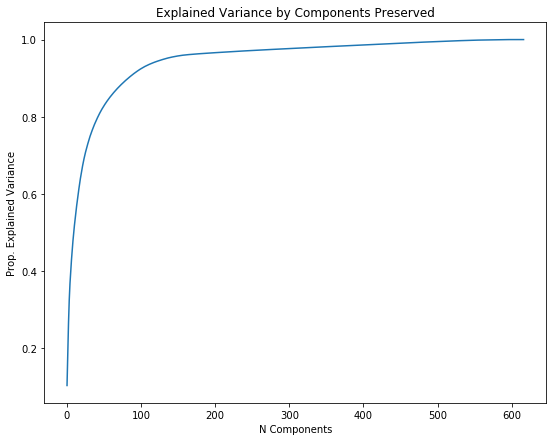

In [19]:
data = pages_text_array

pca = PCA()
data_pca = pca.fit_transform(data)
cum_ratio = np.cumsum(pca.explained_variance_ratio_)

f, ax = plt.subplots(figsize=(9,7))
plt.plot(range(len(cum_ratio)), cum_ratio)
plt.ylabel('Prop. Explained Variance')
plt.xlabel('N Components')
plt.title('Explained Variance by Components Preserved')

This graph illustrates about how many components would be absolutely necessary to expalain variance in the data. Thankfully, it's not too many relative to the number of components available. Each one has over 2,300, but variation is explained by about 100 of them. To be precise, however, I'll defer to a benchmark of using *n* amount of components such that that number of components explain at least 95% of the variance.

In [20]:
index_95 = np.argmax(cum_ratio >= 0.95)
print(index_95)
print(cum_ratio[index_95])

132
0.9500639618794096


Turns out that about 130 components (words) explain pretty much all of the variance.

I'll now visualize the first two components. Together, these components don't explain much of the of the variance in ads but this technique is useful for visualization of clusters.

Text(0.5, 1.0, 'First Two Components')

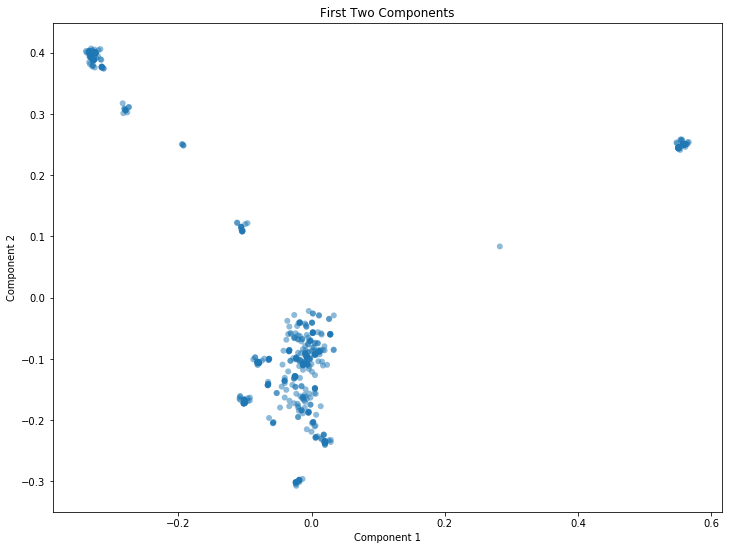

In [21]:
pca = PCA(n_components = 2)
data_pca = pca.fit_transform(data)
f, ax = plt.subplots(figsize = (12,9))
plt.scatter(data_pca[:, 0], data_pca[:, 1],
            cmap='plasma', edgecolor='none', alpha=0.5)
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('First Two Components')

Clustering observations using PCA and then plotting them gave a few insights. First, at least with regards to two dimensions of the data, most observations were not very distinct, save for a few outlier groups. These groups look very dense, but these are very likely duplicate ads that had multiple links attached to them. The lack of distinction between observations - at least as visualized in two dimensions - isn't surprising, given the broad range of language that can be used in advertisements as well as the number of components to which I restricted the analysis. It is encouraging but also reasonable to me that the variance can be explained with relatively so few components. The majority of the words are almost exactly the same across ads. However, this will mean the next step, t-SNE, might not yield many more insights unless I increase the number of components that are considered in the clustering. 

Practically speaking, ads on the Backpage alternative site appear pretty similar at least for this stage in analysis. Thankfully, there are plenty of dimensions (words) to which I can expand analysis and visualization.

### t-SNE

This is another dimensionality reduction technique that is especially used for visualization and not pre-processing. For this technique, the data is reduced to two dimensions so that we can plot the data in this way. The goal of t-SNE is to take the data and represent it correctly in lower dimensions. With t-SNE plots, observations close together in high dimensions remain close together in lower dimensions. 

Practically speaking, this ought to show me how many clusters the data is naturally separated into, though it won't tell me much about the differences between clusters.

In [22]:
#Reduce Dimensionality Before Feeding In
pca = PCA(n_components=132)
data_pca = pca.fit_transform(data)

rows = np.arange(617)
np.random.shuffle(rows)
n_select = 10000

tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=1000, learning_rate=200)
tsne_results = tsne.fit_transform(data_pca[rows[:n_select],:])

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 617 samples in 0.004s...
[t-SNE] Computed neighbors for 617 samples in 0.157s...
[t-SNE] Computed conditional probabilities for sample 617 / 617
[t-SNE] Mean sigma: 0.267484
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.774715
[t-SNE] KL divergence after 1000 iterations: 0.301792


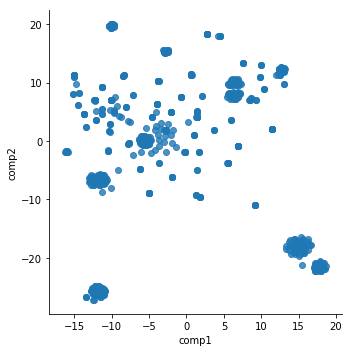

In [23]:
df_tsne = pd.DataFrame(tsne_results, columns=['comp1', 'comp2'])
sns.lmplot(x='comp1', y='comp2', data=df_tsne, fit_reg=False)

### K-Means

I'll finish off with the most famous clustering algorithm - K-Means. It finds some amount, K, of distinct "clusters" in a set of data by using the features of the given data. I have a lot of features here, but each is weighted by it's importance. I have a good idea of the *K* amount of groups that the data ought to be separated in, and t-SNE was also helpful to show how the data might naturally be clustered. Let's see what K-means can tell us about clusters in the data.

As I said, I have a good idea of how many clusters the data might naturally be separated into. On dating sites like the one I scraped, there probably exist several kinds of users that want different things. These might include casual hook-up seekers, prostitutes, or even catfish. Another group might indeed be persons who are being sex trafficked. I therefore imagine that the data might naturally be clustered into **five** groups, but I'd like to see what something like the *Elbow Method* yields for me. 

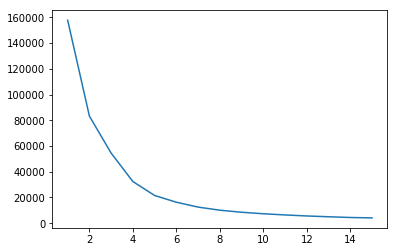

In [26]:
#Elbow Method Code

sses = []
for k in range(1,16):
    kmeans = KMeans(n_clusters=k, n_init=50, n_jobs=-1)
    kmeans.fit(df_tsne[['comp1', 'comp2']])
    sses.append(kmeans.inertia_)
plt.plot(range(1,16), sses)

Oh wow. Similar to what I expected, it appears that the elbow in the code lies at around 5 or 6 clusters in the data. Five clusters seems like a reasonable amount of groups, given what I have already described about the possible groups. Crucially, however, I later found out once the labels were assigned that the clustering was simply finding the duplicate ads on the same landing page. Some ads were posted once a day for several days at a time. My workaround for this is quite crude: I increase the number of clusters so that the duplicate ads will be clustered together and more clusters will hopeflly be determined within the non-duplicate ads. 

The code below does the K-Means clustering for the data again - using a K of 15 - and assigns the labels to each observation. It also returns the Sillhouette Score of the clustering. This ought to be useful to me in that I don't have solid ground truth about the data or the clustering in it. Let's see how it looks:

In [29]:
kmeans_model = KMeans(n_clusters=15, n_init=50, n_jobs=-1)
kmeans_model.fit(data)
labels = kmeans_model.labels_
silhouette_score(data, labels, metric='euclidean')

0.33102455289311383

My Sillhouette Score is not terrible but it's not too great either. It seems that on average the clusters are not very dense and only roughly distinct. 

Next, I'll visualize the clusters that K-Means returned using t-SNE. This won't be much more descriptive than the t-SNE chart above, but here the observations will be labeled with the labels they were assigned by the K-Means algorithm.

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 617 samples in 0.078s...
[t-SNE] Computed neighbors for 617 samples in 2.546s...
[t-SNE] Computed conditional probabilities for sample 617 / 617
[t-SNE] Mean sigma: 0.171359
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.801460
[t-SNE] KL divergence after 1000 iterations: 0.286608


/srv/conda/lib/python3.6/site-packages/seaborn/regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


Text(0.5, 1.0, 'K-Means Clustering')

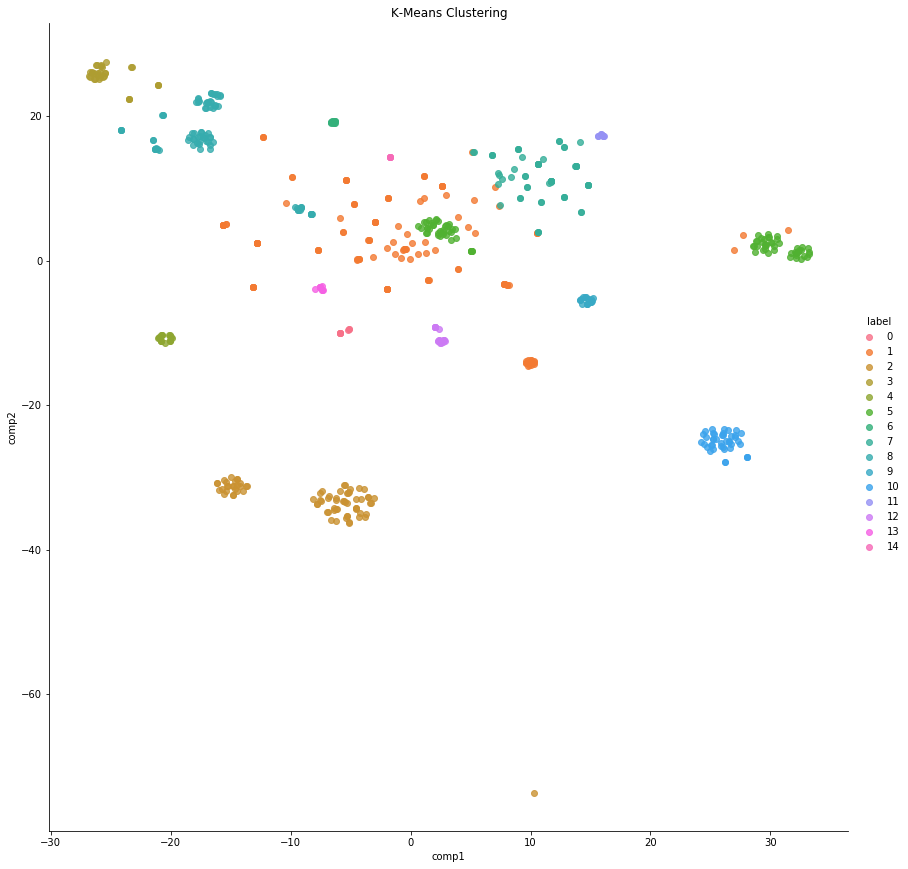

In [34]:
tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=1000, learning_rate=50)
tsne_results = tsne.fit_transform(data[rows[:n_select],:])

df_tsne = pd.DataFrame(tsne_results, columns=['comp1', 'comp2'])
df_tsne['label'] = labels[rows[:n_select]]

sns.lmplot(x='comp1', y='comp2', data=df_tsne, hue='label', fit_reg=False, size=12)
plt.title('K-Means Clustering')

It looks like the clustering did a fair job of pairing the duplicate ads together, and found a few clusters of ads that are not the same but are similar in terms of language. The final step will be to manually investigate these clusters to look for anything suspicious.

## 4. Examining Clusters

**WARNING** - This section contains links to ads that contain highly sensual and personal inormation that is not safe for viewing at work. Use discretion if viewing these links.

Here, I discuss the findings of my analysis. This mostly deals with substantively and quantitatively examining the broad clusters the algorithms found.

To make this simple, I'll combine the links, ad texts, and labels into a dataframe so I can reference the links by labels. The attaching the ad texts is just so that I can delete any duplicate ads in the dataset. Once this is done, I'll drop the ad texts and I'll be left with the links and the labels assigned to those ads by the K-Means Clustering. From there, I'll just manually look at the ads to see if there are distinguishable patterns with regards to ad text.

In [35]:
links = list(links)
print(len(links))
print(len(pages_text))

617
617


In [37]:
links_labels_table = pd.DataFrame({'Links': links, 'Ad Text': pages_text, 'Labels': labels})
links_labels_table.drop_duplicates(subset = "Ad Text", keep = False, inplace = True)
links_labels_table = links_labels_table.drop(['Ad Text'], axis=1)
links_labels_table.shape[0]

585

Only 30 or so ads were exact duplicates, but I still expect there to be several duplicate ads in here that are linked to multiple links because certain posters post ads on different days, different posters may post the same link to the same site or information, etc. 

The last phase is mostly conjecture: I'll print off a sample of ads for each label and read through them. Learning 'feature importances' between groups to determine what words significantly distinguish ads might be useful, but it would take far too long for my purposes.

In [38]:
pd.set_option('display.max_colwidth', -1)
links_labels_table[links_labels_table['Labels'] == 0].head(10)

,Links,Labels
61,https://saltlakecity.bedpage.com/WomenSeekMen/estados-unidos/6612052.html,0
94,https://saltlakecity.bedpage.com/WomenSeekMen/estados-unidos/6733592.html,0
163,https://saltlakecity.bedpage.com/WomenSeekMen/estados-unidos/6581020.html,0
251,https://saltlakecity.bedpage.com/WomenSeekMen/estados-unidos/6722143.html,0
298,https://saltlakecity.bedpage.com/WomenSeekMen/estados-unidos/6754229.html,0
371,https://saltlakecity.bedpage.com/WomenSeekMen/estados-unidos/6763039.html,0
507,https://saltlakecity.bedpage.com/WomenSeekMen/estados-unidos/6762027.html,0
571,https://saltlakecity.bedpage.com/WomenSeekMen/estados-unidos/6730577.html,0


This is a cluster of some duplicate and some unique ads in Spanish. K-Means likely clustered them for similarities in word usage but only because they are all the same language and use similar articles and words.

In [39]:
links_labels_table[links_labels_table['Labels'] == 1].head(10)

,Links,Labels
0,https://saltlakecity.bedpage.com/WomenSeekMen/usa/6706578.html,1
3,https://saltlakecity.bedpage.com/WomenSeekMen/usa/6726627.html,1
5,https://saltlakecity.bedpage.com/WomenSeekMen/usa/6759503.html,1
6,https://saltlakecity.bedpage.com/WomenSeekMen/usa/6658950.html,1
9,https://saltlakecity.bedpage.com/WomenSeekMen/usa/6798992.html,1
11,https://saltlakecity.bedpage.com/WomenSeekMen/usa/6722625.html,1
12,https://saltlakecity.bedpage.com/WomenSeekMen/usa/6700860.html,1
19,https://saltlakecity.bedpage.com/WomenSeekMen/usa/6712210.html,1
22,https://saltlakecity.bedpage.com/WomenSeekMen/usa/6711972.html,1
34,https://saltlakecity.bedpage.com/WomenSeekMen/usa/6722332.html,1


This label very likely encapsulates the "Casual Hook-Uppers" that I postulated would be in the data. Each of these ads emphasized that the poster was currently less than happy, ready to engage in a quick meet-up, and did not make reference to monetary transactions. 

At least one of these ads advertised massage services from multiple asian women. Sexual services were referenced. I am unsure why it was clustered into this group.

In [40]:
links_labels_table[links_labels_table['Labels'] == 2].head(10)

,Links,Labels
7,https://saltlakecity.bedpage.com/WomenSeekMen/usa/7148424.html,2
29,https://saltlakecity.bedpage.com/WomenSeekMen/usa/7196286.html,2
39,https://saltlakecity.bedpage.com/WomenSeekMen/usa/6719645.html,2
46,https://saltlakecity.bedpage.com/WomenSeekMen/usa/6696883.html,2
75,https://saltlakecity.bedpage.com/WomenSeekMen/usa/6762799.html,2
80,https://saltlakecity.bedpage.com/WomenSeekMen/usa/6670600.html,2
100,https://saltlakecity.bedpage.com/WomenSeekMen/usa/6711835.html,2
107,https://saltlakecity.bedpage.com/WomenSeekMen/usa/6698690.html,2
108,https://saltlakecity.bedpage.com/WomenSeekMen/usa/6700815.html,2
109,https://saltlakecity.bedpage.com/WomenSeekMen/usa/7119268.html,2


This is a cluster of duplicate ads from the same poster. This person is likely looking for a casual hook-up as no explicit reference to money and sexual favors was made.

In [41]:
links_labels_table[links_labels_table['Labels'] == 3].head(10)

,Links,Labels
14,https://saltlakecity.bedpage.com/WomenSeekMen/usa/6623537.html,3
62,https://saltlakecity.bedpage.com/WomenSeekMen/usa/6614514.html,3
65,https://saltlakecity.bedpage.com/WomenSeekMen/usa/6619756.html,3
83,https://saltlakecity.bedpage.com/WomenSeekMen/usa/6603817.html,3
111,https://saltlakecity.bedpage.com/WomenSeekMen/usa/6610547.html,3
133,https://saltlakecity.bedpage.com/WomenSeekMen/usa/6617843.html,3
136,https://saltlakecity.bedpage.com/WomenSeekMen/usa/6601497.html,3
139,https://saltlakecity.bedpage.com/WomenSeekMen/usa/6598269.html,3
140,https://saltlakecity.bedpage.com/WomenSeekMen/usa/6593527.html,3
143,https://saltlakecity.bedpage.com/WomenSeekMen/usa/6596433.html,3


This is a cluster of duplicate ads from the same poster. This person is likely looking for a casual hook-up as no explicit reference to money and sexual favors was made.

In [42]:
links_labels_table[links_labels_table['Labels'] == 4].head(10)

,Links,Labels
36,https://saltlakecity.bedpage.com/WomenSeekMen/taylorsville/6758656.html,4
84,https://saltlakecity.bedpage.com/WomenSeekMen/taylorsville/7119160.html,4
91,https://saltlakecity.bedpage.com/WomenSeekMen/taylorsville/7805336.html,4
97,https://saltlakecity.bedpage.com/WomenSeekMen/taylorsville/6758666.html,4
284,https://saltlakecity.bedpage.com/WomenSeekMen/taylorsville/7191725.html,4
300,https://saltlakecity.bedpage.com/WomenSeekMen/taylorsville/6764022.html,4
339,https://saltlakecity.bedpage.com/WomenSeekMen/taylorsville/6798577.html,4
387,https://saltlakecity.bedpage.com/WomenSeekMen/taylorsville/6767686.html,4
400,https://saltlakecity.bedpage.com/WomenSeekMen/taylorsville/7190694.html,4
409,https://saltlakecity.bedpage.com/WomenSeekMen/taylorsville/6763241.html,4


This is a cluster of duplicate ads from the same poster, but they all advertise the grand opening of an Asian Massage service in Salt Lake. No explicit reference is made to money or sexual favors, but all ads feature photos of scantily clad Asian women.

In [43]:
links_labels_table[links_labels_table['Labels'] == 5].head(10)

,Links,Labels
10,https://saltlakecity.bedpage.com/WomenSeekMen/usa/7193841.html,5
13,https://saltlakecity.bedpage.com/WomenSeekMen/usa/6639184.html,5
15,https://saltlakecity.bedpage.com/WomenSeekMen/usa/6618072.html,5
16,https://saltlakecity.bedpage.com/WomenSeekMen/usa/6590221.html,5
25,https://saltlakecity.bedpage.com/WomenSeekMen/usa/6689605.html,5
27,https://saltlakecity.bedpage.com/WomenSeekMen/usa/6732436.html,5
32,https://saltlakecity.bedpage.com/WomenSeekMen/usa/7148457.html,5
38,https://saltlakecity.bedpage.com/WomenSeekMen/usa/6605164.html,5
40,https://saltlakecity.bedpage.com/WomenSeekMen/usa/7792046.html,5
42,https://saltlakecity.bedpage.com/WomenSeekMen/usa/6652918.html,5


This is a cluster of duplicate ads from the same poster. This person is likely looking for a casual hook-up as no explicit reference to money and sexual favors was made.

In [44]:
links_labels_table[links_labels_table['Labels'] == 6].head(10)

,Links,Labels
79,https://saltlakecity.bedpage.com/WomenSeekMen/usa/7246001.html,6
105,https://saltlakecity.bedpage.com/WomenSeekMen/usa/7191750.html,6
151,https://saltlakecity.bedpage.com/WomenSeekMen/usa/7195904.html,6
189,https://saltlakecity.bedpage.com/WomenSeekMen/usa/6767759.html,6
275,https://saltlakecity.bedpage.com/WomenSeekMen/usa/7148519.html,6
306,https://saltlakecity.bedpage.com/WomenSeekMen/usa/6863392.html,6
332,https://saltlakecity.bedpage.com/WomenSeekMen/usa/7792661.html,6
412,https://saltlakecity.bedpage.com/WomenSeekMen/usa/7194406.html,6
432,https://saltlakecity.bedpage.com/WomenSeekMen/usa/6764503.html,6
590,https://saltlakecity.bedpage.com/WomenSeekMen/usa/6769832.html,6


This is a cluster of duplicate ads from the same poster. It is unclear whether this person is a prostitute or seeking a casual hook-up as these ads repeat the words "service" or "services" but do not show prices or reference to money.

In [45]:
links_labels_table[links_labels_table['Labels'] == 7].head(10)

,Links,Labels
31,https://saltlakecity.bedpage.com/WomenSeekMen/united-states/6651383.html,7
41,https://saltlakecity.bedpage.com/WomenSeekMen/united-states/7194408.html,7
55,https://saltlakecity.bedpage.com/WomenSeekMen/united-states/7198198.html,7
58,https://saltlakecity.bedpage.com/WomenSeekMen/united-states/6709853.html,7
74,https://saltlakecity.bedpage.com/WomenSeekMen/united-states/6724587.html,7
98,https://saltlakecity.bedpage.com/WomenSeekMen/united-states/6709855.html,7
104,https://saltlakecity.bedpage.com/WomenSeekMen/united-states/6707492.html,7
117,https://saltlakecity.bedpage.com/WomenSeekMen/united-states/7196327.html,7
124,https://saltlakecity.bedpage.com/WomenSeekMen/united-states/7192519.html,7
130,https://saltlakecity.bedpage.com/WomenSeekMen/united-states/6709854.html,7


These are mostly ads to other websites or escort services. For most of them, no phone number or email address is provided but a forwarding url that leads to the new service is.

In [46]:
links_labels_table[links_labels_table['Labels'] == 8].head(10)

,Links,Labels
1,https://saltlakecity.bedpage.com/WomenSeekMen/usa/6720224.html,8
17,https://saltlakecity.bedpage.com/WomenSeekMen/usa/6711536.html,8
18,https://saltlakecity.bedpage.com/WomenSeekMen/usa/6730153.html,8
20,https://saltlakecity.bedpage.com/WomenSeekMen/usa/6660851.html,8
21,https://saltlakecity.bedpage.com/WomenSeekMen/usa/6732820.html,8
24,https://saltlakecity.bedpage.com/WomenSeekMen/usa/7119400.html,8
37,https://saltlakecity.bedpage.com/WomenSeekMen/usa/6732437.html,8
43,https://saltlakecity.bedpage.com/WomenSeekMen/usa/6717657.html,8
44,https://saltlakecity.bedpage.com/WomenSeekMen/usa/6762758.html,8
60,https://saltlakecity.bedpage.com/WomenSeekMen/usa/6715499.html,8


This is a cluster of duplicate ads from the same poster. This person is likely a prostitute given her use of slang referring to sexual services as well as her referencing the need to "pre-book" a meeting.

In [47]:
links_labels_table[links_labels_table['Labels'] == 9].head(10)

,Links,Labels
28,https://saltlakecity.bedpage.com/WomenSeekMen/usa/6705428.html,9
134,https://saltlakecity.bedpage.com/WomenSeekMen/usa/6718247.html,9
155,https://saltlakecity.bedpage.com/WomenSeekMen/usa/7805960.html,9
245,https://saltlakecity.bedpage.com/WomenSeekMen/usa/7246214.html,9
308,https://saltlakecity.bedpage.com/WomenSeekMen/usa/6728718.html,9
320,https://saltlakecity.bedpage.com/WomenSeekMen/usa/6716474.html,9
427,https://saltlakecity.bedpage.com/WomenSeekMen/usa/7198337.html,9
471,https://saltlakecity.bedpage.com/WomenSeekMen/usa/6767834.html,9
602,https://saltlakecity.bedpage.com/WomenSeekMen/usa/6714225.html,9
611,https://saltlakecity.bedpage.com/WomenSeekMen/usa/7792882.html,9


This is a cluster of duplicate ads from a separate dating site.

In [48]:
links_labels_table[links_labels_table['Labels'] == 10].head(10)

,Links,Labels
2,https://saltlakecity.bedpage.com/WomenSeekMen/usa/6863223.html,10
4,https://saltlakecity.bedpage.com/WomenSeekMen/usa/6676132.html,10
30,https://saltlakecity.bedpage.com/WomenSeekMen/usa/6725948.html,10
33,https://saltlakecity.bedpage.com/WomenSeekMen/usa/6764985.html,10
35,https://saltlakecity.bedpage.com/WomenSeekMen/usa/6680492.html,10
47,https://saltlakecity.bedpage.com/WomenSeekMen/usa/6769671.html,10
119,https://saltlakecity.bedpage.com/WomenSeekMen/usa/6721740.html,10
158,https://saltlakecity.bedpage.com/WomenSeekMen/usa/6727824.html,10
161,https://saltlakecity.bedpage.com/WomenSeekMen/usa/6700826.html,10
169,https://saltlakecity.bedpage.com/WomenSeekMen/usa/7194283.html,10


This is a cluster of duplicate ads from the same poster. This person is likely seeking a casual hook-up as she explicitly stated she does *not* need/want money.

In [49]:
links_labels_table[links_labels_table['Labels'] == 11].head(10)

,Links,Labels
103,https://saltlakecity.bedpage.com/WomenSeekMen/united-states/6719673.html,11
198,https://saltlakecity.bedpage.com/WomenSeekMen/united-states/6722339.html,11
382,https://saltlakecity.bedpage.com/WomenSeekMen/united-states/6734552.html,11
391,https://saltlakecity.bedpage.com/WomenSeekMen/united-states/6708621.html,11
446,https://saltlakecity.bedpage.com/WomenSeekMen/united-states/6735163.html,11
478,https://saltlakecity.bedpage.com/WomenSeekMen/united-states/6759353.html,11
479,https://saltlakecity.bedpage.com/WomenSeekMen/united-states/6708622.html,11
525,https://saltlakecity.bedpage.com/WomenSeekMen/united-states/6722345.html,11
532,https://saltlakecity.bedpage.com/WomenSeekMen/united-states/6720261.html,11


This is a cluster of duplicate ads from a separate dating site.

In [51]:
links_labels_table[links_labels_table['Labels'] == 12].head(10)

,Links,Labels
8,https://saltlakecity.bedpage.com/WomenSeekMen/salt-lake-city-ut-usa/6659473.html,12
54,https://saltlakecity.bedpage.com/WomenSeekMen/salt-lake-city-ut-usa/6644458.html,12
63,https://saltlakecity.bedpage.com/WomenSeekMen/salt-lake-city-ut-usa/6643113.html,12
71,https://saltlakecity.bedpage.com/WomenSeekMen/salt-lake-city-ut-usa/6618782.html,12
78,https://saltlakecity.bedpage.com/WomenSeekMen/salt-lake-city-ut-usa/6647509.html,12
85,https://saltlakecity.bedpage.com/WomenSeekMen/salt-lake-city-ut-usa/6588742.html,12
250,https://saltlakecity.bedpage.com/WomenSeekMen/salt-lake-city-ut-usa/6647042.html,12
304,https://saltlakecity.bedpage.com/WomenSeekMen/salt-lake-city-ut-usa/6649828.html,12
327,https://saltlakecity.bedpage.com/WomenSeekMen/salt-lake-city-ut-usa/6650151.html,12
333,https://saltlakecity.bedpage.com/WomenSeekMen/salt-lake-city-ut-usa/6655541.html,12


This is a cluster of two sets of duplicate ads from two different posters. One expressly stated she would exchange sexual favors for money.

In [52]:
links_labels_table[links_labels_table['Labels'] == 13].head(10)

,Links,Labels
129,https://saltlakecity.bedpage.com/WomenSeekMen/usa/6718245.html,13
145,https://saltlakecity.bedpage.com/WomenSeekMen/usa/6711978.html,13
212,https://saltlakecity.bedpage.com/WomenSeekMen/usa/6726788.html,13
334,https://saltlakecity.bedpage.com/WomenSeekMen/usa/6716471.html,13
357,https://saltlakecity.bedpage.com/WomenSeekMen/usa/6726791.html,13
366,https://saltlakecity.bedpage.com/WomenSeekMen/usa/6705595.html,13
461,https://saltlakecity.bedpage.com/WomenSeekMen/usa/6765907.html,13
564,https://saltlakecity.bedpage.com/WomenSeekMen/usa/7196546.html,13


This is a cluster of duplicate ads from a separate dating site.

In [54]:
links_labels_table[links_labels_table['Labels'] == 14].head(10)

,Links,Labels
26,https://saltlakecity.bedpage.com/WomenSeekMen/ee-uu/6646708.html,14
131,https://saltlakecity.bedpage.com/WomenSeekMen/ee-uu/6655365.html,14
419,https://saltlakecity.bedpage.com/WomenSeekMen/ee-uu/6648935.html,14
513,https://saltlakecity.bedpage.com/WomenSeekMen/ee-uu/6651230.html,14
609,https://saltlakecity.bedpage.com/WomenSeekMen/ee-uu/6652485.html,14


This is a cluster of duplicate ads from the same poster. It is unclear whether this person is a prostitute or seeking a casual hook-up as these are a mix of English and Spanish.

## Findings

In this section, I do a brief overview of my findings and broad evaluations of clusters. I do not make specific mention of clusters of duplicate ads but instead speak them as being either seeking casual hook-ups, being more likely to be prostitutes, or otherwise. Here, I only evaluate clusters that I saw led to real people or real people's direct contact information. I lastly conjecture as to which clusters, if any, are more likely to be victims of sex trafficking.

**Label 1 - Casual Hook-Uppers** - This group was full of ads that were very laid-back, informal, and time-insensitive in their tone. For all of the ads in sample of this type of ad that I examined, no mention of money exchange was made.

At least one ad in this group, however, advertised asian massage services of multiple women. Reference was made to sexual favors that could be performed by these women.

**Labels 4, 8, and 12 - Likely Prostitutes** - These clusters were all duplicate ads to the same persons or organizations that advertised sexual favors and made reference to rates, or used language expressly used by prostitutes to discreetly convey the types of sexual favors they may offer. 

One of these clusters was a group of advertisements to another asian massage parlor in Salt Lake. Nothing in the ad text made reference to sexual favors, but it was highly insinuated given the nature of the photographs attached to the ad. 

**Summary of Other Labels** - of the sample of the other clusters I examined, many of them appeared to be supposed "ads" that were actually just generic links to other dating sites. I imagine that bigger dating sites would put links to their services on local websites like this to broaden their reach.

There were also several other clusters of ads by people that were likely seeking casual hook-ups. This much could be gleaned by their ads because of their explicit declining of need for money and certain of their mentioning not being particular with regards to race, age, gender, or even attractiveness.

## Conclusion

To briefly summarize, this project, at the substantive level, led me to several ads or types of ads that may be attached to trafficked persons, but this is hard to tell given the unclear distinction (at least with regards to ad language) between prostitutes and sex trafficked individuals. It also happened to lead me to a number of ads for sexual favors from *multiple* persons of foreign origin, but it did not do so by virtue of how the algorithm worked. The algorithm did, however, do reasonably well at ruling out those who were merely seeking a casual hook-up. Substantively, the project caused me to think deeply about the policy implications for combatting sex trafficking, especially as these relate to the legality (or lack thereof) of sex work and sex workers.

At the more analytical level, the project was a crash course in several packages and tools I had never used or knew existed before. I constantly had to think outside of the box and ask the right questions to get around new problems. Unsupervised machine learning is simple and useful for datasets without labels, but it comes without all of the benefits of supervised learning. Namely, clustering could not describe the patterns that distinguished groups, nor could it formulate a prediction model for data that it had not enountered before.

I ran into a number of limitations. The first was a lack of unique data. This could have reasonably been overcome by expanding the number of links I took from the website, but even on the third landing page of links there were vast amounts of duplicate links. More reasonably, I might try this same kind of process on another dating site that doesn't allow for re-posting the same ad twice and works more by accounts. The biggest problem was that K-Means was essentially foiled because of all of the duplicate ads. What I ought to have done to address these is find a way to delete them while they were still in the array form. I could have specified that the vocabulary drop all words relating to month and day of posting so that the vectorizer would have made these ads essentially the same in the array format. While my workaround was quite crude, however, it mostly satisfied my purposes and allowed me to roughly delineate at least the prostitutes from the non-prostitutes. A dataset with labels would similarly have made classification simpler. More important then allowing me to make predictions, it would have informed my understanding about what factors likely identify sex trafficking victims as opposed to other groups.